# Parameter sensitivity analysis

[The cluster selection strategies notebook](./demo_selection_strategies.ipynb)
demonstrates ``plscan`` is less sensitive to the ``min_samples`` parameter ($k$)
than ``hdbscan``. This notebook runs a more comprehensive parameter sensitivity
analysis to determine whether that pattern holds on other datasets. This
parameter sensitivity analysis tells us how the clustering quality changes as a
result of changing $k$. The resulting value is independent of $k$ itself.
Instead they relate to a change in $k$: $\Delta k$!

We apply the analysis [Peng et al.
2022](https://www.nature.com/articles/s41467-022-33136-9#Sec18) used to evaluate
their clustering algorithm. They modified a "Latin-Hypercube
One-factor-At-a-Time (LH-OAT)" analysis. This sounds more complicated than it
is, especially for algorithms with a single parameter. The steps are as follows:

- Choose a parameter $k$ and divided its value-space in regularly sized
  segments.
- Choose a constant perturbation $\Delta v$ to evaluate.
- Sample values $v$ in each segment. We denote the set of sampled values with
  $V$. 
- Perturb the sampled values with $\pm \Delta v$, randomly choosing the positive
  or negative direction.
- Compute the algorithm's clustering quality scores at $v$ and $v \pm \Delta v$.
  For example, using the
  [ARI](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html).
  We denote this score as $ARI(k=v)$, indicating a score at parameter value
  $k=v$.
- Compute the sensitivity at $\Delta v$ using: 
$$
  s_{\Delta v} = \frac{1}{|V|} \sum_{v \in V} \left|\frac{ARI(k=v \pm \Delta v) - ARI(k=v)} {ARI(k=v \pm\Delta v) + ARI(k=v)}\right|. 
$$

We want to evaluate the sensitivity for multiple perturbation sizes $\Delta v$,
algorithm configurations, and datasets. Our implementation splits the work in
three stages and considers several clustering quality measures:

1. Sample the parameter and perturbations, collecting all parameter values to
   evaluate.
2. Compute the algorithms' clustering quality measures values on all datasets
   with the collected parameter values. Store these values!
3. Use the computed quality measures values to compute average sensitivities for
   each perturbation size.

In [ ]:
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import product
from scipy.stats import rankdata
from collections import defaultdict
from sklearn.datasets import fetch_openml

from umap import UMAP
from lensed_umap import embed_graph

from plscan import PLSCAN
from hdbscan import HDBSCAN
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score

from lib.plotting import *
from lib.drawing import regplot_lowess_ci


configure_matplotlib()  # uses latex for text rendering!
data = np.load("data/clusterable/sources/clusterable_data.npy")

## 1. Sample parameter values and perturbations

This cell performs the parameter value sampling and applies perturbations at
multiple sizes. The process is repeated five times (vectorized) and all unique
parameter values required for the sensitivity computation are collected.

Perturbations that create invalid values (<2) are ignored!

In [ ]:
# configuration
repeats = 5
num_segments = 15
min_sample_range = (2, 500)
deltas = np.array([[5], [10], [15], [20]])

# sampled values
segments = np.linspace(*min_sample_range, num_segments + 1, dtype=int)
samples = np.random.uniform(segments[:-1], segments[1:], size=(repeats, num_segments))
min_sample_sizes = np.round(samples).astype(int).T

# perturbed values
directions = np.random.choice((-1, 1), size=(deltas.shape[0], num_segments, repeats))
perturbations = directions * deltas[:, :, np.newaxis]
new_values = min_sample_sizes[np.newaxis, :, :] + perturbations

# all values to evaluate
all_values = np.concatenate((min_sample_sizes.flatten(), new_values.flatten()))
all_values = np.unique(all_values)
all_values = all_values[(all_values >= 2)]

np.save("data/generated/benchmark_sensitivity_deltas.npy", deltas)
np.save("data/generated/benchmark_sensitivity_min_sizes.npy", min_sample_sizes)
np.save("data/generated/benchmark_sensitivity_perturbed_values.npy", new_values)

## 2. Compute quality measures

This stage computes clustering quality measures at the sampled parameter values.

First, we configure the datasets. This step assumes all dataset have been
downloaded and pre-processed before running this notebook. See instructions at
`docs/data/[data-set]/README.md`!

In [9]:
def load_mnist():
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True)
    return X, y.cat.codes.to_numpy().astype(np.intp)


def load_fashion_mnist():
    X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True)
    return X, y.cat.codes.to_numpy().astype(np.intp)


def load_20newsgroups():
    """See data/newsgroups/README.md for details."""
    X = np.load("data/newsgroups/generated/X_20newsgroups.npy")
    y = np.load("data/newsgroups/generated/y_20newsgroups.npy")
    return X, y.astype(np.intp)


def load_elegans():
    """See data/elegans/README.md for details."""
    X = np.load("data/elegans/generated/X_elegans.npy")
    y = np.load("data/elegans/generated/y_elegans.npy")
    return X, y.astype(np.intp)


def load_audioset_music():
    """See data/audioset/README.md for details."""
    X = np.load("data/audioset/generated/X_music.npy")
    y = np.load("data/audioset/generated/y_music.npy")
    return X, y.astype(np.intp)


data_configs = dict(
    mnist=load_mnist,
    fashion_mnist=load_fashion_mnist,
    newsgroups=load_20newsgroups,
    elegans=load_elegans,
    audioset_music=load_audioset_music,
)

Next, we implement the clustering quality measures:

In [10]:
def compute_quality(true_labels, predicted_labels):
    ari = adjusted_rand_score(true_labels, predicted_labels)
    homogeneity = homogeneity_score(true_labels, predicted_labels)
    completeness = completeness_score(true_labels, predicted_labels)
    mutual_info = 2.0 * homogeneity * completeness / (homogeneity + completeness)
    return ari, homogeneity, completeness, mutual_info

Then, we create functions that evaluate the algorithms. These functions return
one or more records identifying the dataset, algorithm configuration, and
resulting quality scores. For `plscan`, we compute scores for its top-$n$
layers:

In [11]:
def evaluate_hdbscan(X, y, data_name, k, alg_name, params, post_params):
    labels = HDBSCAN(min_samples=k, min_cluster_size=k, **params).fit_predict(X)
    ari, homogeneity, completeness, mutual_info = compute_quality(y, labels)
    return [
        dict(
            ari=ari,
            homogeneity=homogeneity,
            completeness=completeness,
            mutual_info=mutual_info,
            data_set=data_name,
            k=k,
            alg_id="_".join([alg_name] + [f"{v}" for v in params.values()]),
            alg_config={"algorithm": alg_name, **params},
        )
    ]

In [ ]:
def evaluate_plscan(X, y, data_name, k, alg_name, params, post_params):
    # Compute PLSCAN layers
    c = PLSCAN(min_samples=k, min_cluster_size=k, **params).fit(X)
    layers = c.cluster_layers(**post_params) or [(k, c.labels_, c.probabilities_)]
    
    # Rank layers by their persistence score
    sizes, pers = c._persistence_trace
    sizes = sizes if sizes.shape[0] > 0 else np.array([k], dtype=np.float32)
    pers = pers if pers.shape[0] > 0 else np.array([0.0], dtype=np.float32)
    s = [s for s, _, _ in layers]
    ranks = rankdata(-pers[np.searchsorted(sizes, s)], method="ordinal")
    records = []
    
    # Create a record and compute quality for each layer
    for peak, (size, labels, _) in zip(ranks, layers):
        ari, homogeneity, completeness, mutual_info = compute_quality(y, labels)
        records.append(
            dict(
                ari=ari,
                homogeneity=homogeneity,
                completeness=completeness,
                mutual_info=mutual_info,
                data_set=data_name,
                k=k,
                alg_id="_".join(
                    [alg_name] + [f"{v}" for v in params.values()] + [f"{peak}"]
                ),
                alg_config={
                    "algorithm": alg_name,
                    **params,
                    "peak": peak,
                    "birth_size": size,
                },
            )
        )
    return records

Next, we specify the algorithm--parameter configurations. We want to evaluate
all parameter-value combinations. In this case, only the cluster selection
strategies vary.

In [13]:
# Configurations
algorithms = dict(plscan=evaluate_plscan, hdbscan=evaluate_hdbscan)
in_params = defaultdict(
    dict,
    plscan=dict(persistence_measure=["size", "size-distance", "size-density"]),
    hdbscan=dict(cluster_selection_method=["leaf", "eom"]),
)
post_params = defaultdict(dict, plscan=dict(n_peaks=[4]))
algorithm_configs = [
    (
        fun,
        name,
        {param: value for param, value in zip(in_params[name].keys(), param_values)},
        {
            param: value
            for param, value in zip(post_params[name].keys(), post_param_values)
        },
    )
    for name, fun in algorithms.items()
    for param_values in product(*in_params[name].values())
    for post_param_values in product(*post_params[name].values())
]

Finally, run all algorithm--dataset--$k$ combinations (takes about 3 hours). 

We project all datasets down to 50 dimension using UMAP. We slowly increase
UMAP's repulsion strength parameter to avoid self-intersections in the layout.
The `set_op_mix_ratio` parameter increases cluster separation in the layout.
This step could be tuned for each dataset to increase performance. We are mostly
interested in parameter stability, though, so these settings are good enough.

In [ ]:
records = []

pbar = tqdm(total=len(data_configs) * len(all_values) * len(algorithm_configs))
for data_name, loader in data_configs.items():
    # Load the data
    X, y = loader()

    # Project down to 50 dimensions with UMAP.
    # Repeats the layout procedure with increasing repulsion to avoid overlaps
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p = UMAP(
            n_components=50,
            n_neighbors=250,
            metric="cosine",
            set_op_mix_ratio=0.1,
            transform_mode="graph",
        ).fit(X)
        p = embed_graph(p, repulsion_strengths=[0.001, 0.01, 0.1, 1])

    # Evaluate the algorithms
    for k, (evaluator, alg_name, params, post_params) in product(
        all_values, algorithm_configs
    ):
        records.extend(
            evaluator(p.embedding_, y, data_name, k, alg_name, params, post_params)
        )
        pbar.update()


df = pd.DataFrame.from_records(records)
df.to_parquet("data/generated/benchmark_sensitivity.parquet")
df.head()

100%|██████████| 6800/6800 [2:58:37<00:00,  2.40s/it]   

,ari,homogeneity,completeness,mutual_info,data_set,k,alg_id,alg_config
0,0.190297,0.570541,0.590652,0.580422,mnist,5,plscan_size_4,"{'algorithm': 'plscan', 'persistence_measure':..."
1,0.920710,0.923450,0.897375,0.910226,mnist,5,plscan_size_1,"{'algorithm': 'plscan', 'persistence_measure':..."
2,0.657180,0.753125,0.933298,0.833587,mnist,5,plscan_size_2,"{'algorithm': 'plscan', 'persistence_measure':..."
3,0.432134,0.535315,0.929862,0.679466,mnist,5,plscan_size_3,"{'algorithm': 'plscan', 'persistence_measure':..."
4,0.128724,0.524443,0.547776,0.535856,mnist,5,plscan_size-distance_4,"{'algorithm': 'plscan', 'persistence_measure':..."


## 2.5 Plot the results

This section plots the $k$--quality curves for all evaluated algorithms
configurations and datasets.

First, we load the data generated by the previous steps.

In [2]:
df = pd.read_parquet("data/generated/benchmark_sensitivity.parquet")
deltas = np.load("data/generated/benchmark_sensitivity_deltas.npy")
min_sample_sizes = np.load("data/generated/benchmark_sensitivity_min_sizes.npy")
new_values = np.load("data/generated/benchmark_sensitivity_perturbed_values.npy")

Then, we configure display names for the variables and values.

In [3]:
def to_display_name(input):
    parts = input.split("_")
    name = parts[0].upper()
    if name == "HDBSCAN":
        name = "HDBSCAN*"
        return f"{name} ({' '.join(parts[1:])})"
    if name == "PLSCAN":
        params = [
            p.replace("-", "--")
            .replace("density", r"$\lambda$")
            .replace("distance", "$d$")
            for p in parts[1:]
        ]
        return f"{name} ({' '.join(params)})"
    return input


def dataset_name(input):
    names = dict(
        mnist="MNIST",
        fashion_mnist="Fashion-MNIST",
        newsgroups="20 Newsgroups",
        elegans="C.~elegans",
        audioset_music="AudioSet (music)",
    )
    return names.get(input, input)

Next, we summarize PLSCAN's layers into the default (most-persistent) layer, and
the optimal layer at each $k$. The latter strategy mimics a workflow that
manually inspects and selects a cluster layer when tuning the algorithm.

In [4]:
# Create new data frame without the rows for non-default plscan layers
def digit_higher_than_one(char):
    return char.isdigit() and int(char) > 1


mask = df.alg_id.apply(lambda x: not digit_higher_than_one(x.split("_")[-1]))
df_default = df[mask].copy()
df_default.alg_id = df_default.alg_id.apply(
    lambda x: x if "plscan" not in x else "_".join(x.split("_")[:-1])
)

In [5]:
# Select rows with the best plscan layer at each dataset--k
plscan_df = df.query("alg_id.str.startswith('plscan')", engine="python").copy()
plscan_df["persistence"] = plscan_df.alg_id.apply(lambda x: x.split("_")[1])
plscan_df["layer"] = plscan_df.alg_id.apply(lambda x: x.split("_")[-1])
best_layer = (
    plscan_df.groupby(["data_set", "persistence", "k"])
    .apply(lambda g: g.loc[g.mutual_info.idxmax()], include_groups=False)
    .reset_index()
)
best_layer.alg_id = best_layer.alg_id.apply(
    lambda x: "_".join(x.split("_")[:-1] + ["top"])
)
best_layer = best_layer.drop(columns=["layer", "persistence"])

In [6]:
# Combine these dataframes
df_top = pd.concat((df_default, best_layer), ignore_index=True)
df_top.groupby(["data_set", "alg_id"]).apply(
    lambda g: g.loc[g.mutual_info.idxmax(), ["ari", "mutual_info"]],
    include_groups=False,
).reset_index().round(3).pivot(
    index="alg_id", columns="data_set", values=["ari", "mutual_info"]
)

ari                               \
data_set                 audioset_music elegans fashion_mnist  mnist   
alg_id                                                                 
hdbscan_eom                       0.071   0.366         0.444  0.941   
hdbscan_leaf                      0.021   0.310         0.079  0.683   
plscan_size                       0.042   0.364         0.415  0.931   
plscan_size-density               0.042   0.335         0.148  0.657   
plscan_size-density_top           0.042   0.336         0.457  0.931   
plscan_size-distance              0.042   0.335         0.148  0.657   
plscan_size-distance_top          0.042   0.336         0.457  0.931   
plscan_size_top                   0.042   0.333         0.457  0.931   

                                       mutual_info                        \
data_set                 newsgroups audioset_music elegans fashion_mnist   
alg_id                                                                     
hdbscan_eom                   0.099          0.275   0.671         0.660   
hdbscan_leaf                  0.053          0.250   0.641         0.409   
plscan_size                   0.088          0.261   0.651         0.608   
plscan_size-density           0.100          0.261   0.614         0.414   
plscan_size-density_top       0.065          0.261   0.662         0.632   
plscan_size-distance          0.096          0.261   0.614         0.414   
plscan_size-distance_top      0.095          0.261   0.662         0.632   
plscan_size_top               0.095          0.261   0.654         0.632   

                                            
data_set                  mnist newsgroups  
alg_id                                      
hdbscan_eom               0.925      0.411  
hdbscan_leaf              0.811      0.385  
plscan_size               0.917      0.390  
plscan_size-density       0.834      0.380  
plscan_size-density_top   0.917      0.398  
plscan_size-distance      0.834      0.395  
plscan_size-distance_top  0.917      0.396  
plscan_size_top           0.917      0.396

Next, we configure the colors, titles, and plotting orders:

In [43]:
# Configure plotting order, colors and titles
plot_df = df_top.copy()
data_sets = sorted(plot_df.data_set.unique())
alg_ids = [
    "hdbscan_eom",
    "hdbscan_leaf",
    "plscan_size_top",
    "plscan_size",
    "plscan_size-distance_top",
    "plscan_size-distance",
    "plscan_size-density_top",
    "plscan_size-density",
]
palette = [
    mpl.colors.to_rgb("C0"),
    mpl.colors.to_rgb("C1"),
    lighten("C2"),
    mpl.colors.to_rgb("C2"),
    lighten("C3"),
    mpl.colors.to_rgb("C3"),
    lighten("C4"),
    mpl.colors.to_rgb("C4"),
]
titles = [
    "HDBSCAN*\nEOM/leaf",
    "PLSCAN\nsize",
    "PLSCAN\nsize--$d$",
    "PLSCAN\nsize--$\\lambda$",
]

Now, we plot the mutual information as a curve over $k$. We interested in the
range of $k$ values for which the algorithms produce high quality clusterings.

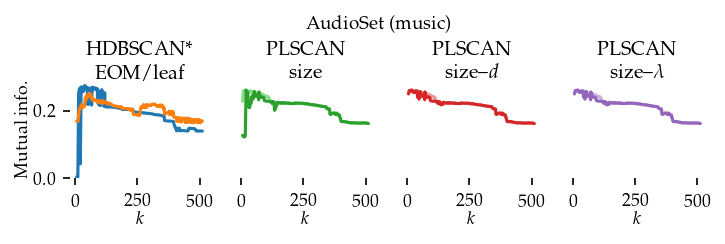

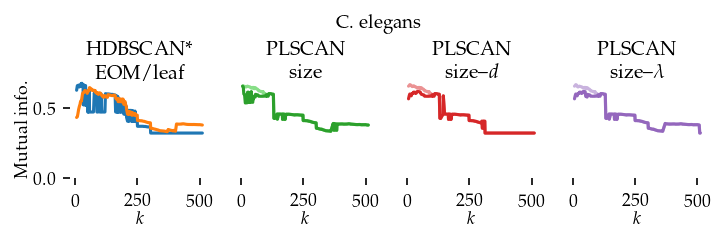

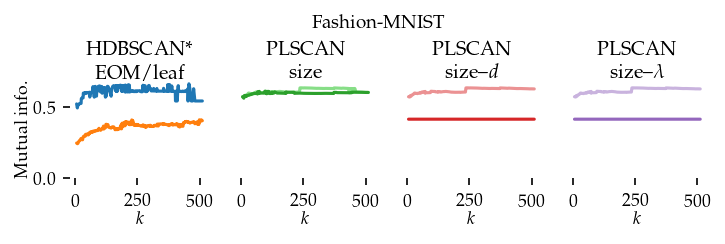

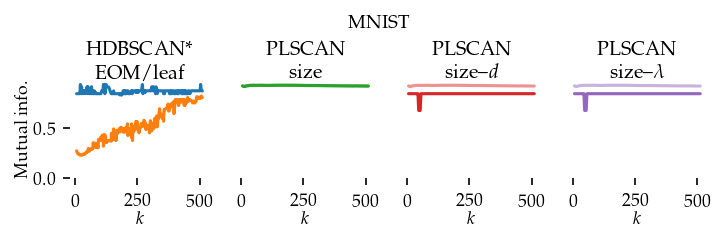

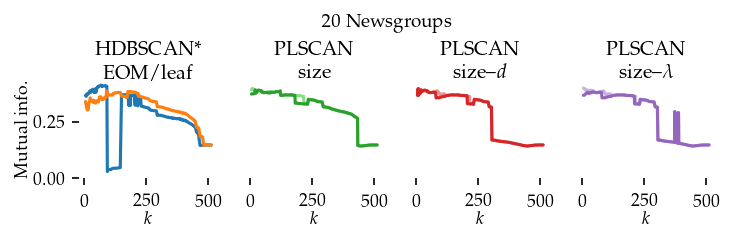

In [31]:
# Create the plots
for i, data_name in enumerate(data_sets):
    sized_fig(1, 0.618 / 4)
    plt.suptitle(f"{dataset_name(data_name)}", y=1.4)
    for j, ids in enumerate([[0, 1], [2, 3], [4, 5], [6, 7]]):
        plt.subplot(1, 4, j + 1)
        sns.lineplot(
            data=plot_df.query(f'data_set == "{data_name}"'),
            x="k",
            y="mutual_info",
            hue="alg_id",
            hue_order=[alg_ids[idx] for idx in ids],
            errorbar=None,
            palette=[palette[idx] for idx in ids],
            legend=False,
        )
        plt.title(titles[j], y=0.9)
        plt.xlabel("$k$", labelpad=0)
        plt.xticks([0, 250, 500])
        if j == 0:
            plt.ylabel("Mutual info.", labelpad=0)
            ylim = plt.ylim(0, None)
        else:
            plt.ylim(ylim)
            plt.ylabel("")
            plt.yticks([])
plt.show()

Next, we summarize the shape of the curves over all datasets by Lowess
interpolation. We scaled the mutual information scores by the maximum value
achieved on each dataset to compare the curves, rather than the exact values.
Still, this interpolation has issues because some datasets need other $k$ values
to get good clusters.

In [44]:
def scale_quality(group):
    max_q = group.mutual_info.max()
    group["scaled_quality"] = group.mutual_info / max_q
    return group


plot_df = (
    plot_df.groupby(["data_set"])
    .apply(scale_quality, include_groups=False)
    .reset_index()
)

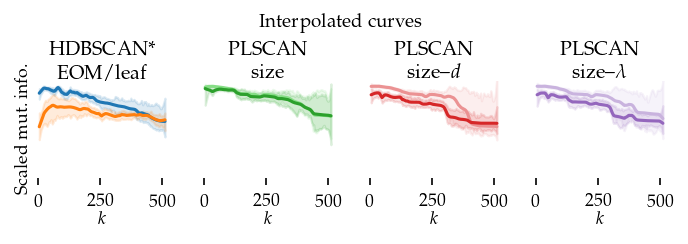

In [46]:
sized_fig(1, 0.618 / 4)
plt.suptitle("Interpolated curves", y=1.4)
for j, ids in enumerate([[0, 1], [2, 3], [4, 5], [6, 7]]):
    plt.subplot(1, 4, j + 1)
    for i, idx in enumerate(ids):
        alg_id = alg_ids[idx]
        regplot_lowess_ci(
            plot_df.query(f'alg_id == "{alg_id}"'),
            x="k",
            y="scaled_quality",
            ci_level=99,
            n_boot=100,
            lowess_frac=0.05,
            color=palette[idx],
            scatter=False,
        )
        plt.title(titles[j], y=0.9)
        plt.xlabel("$k$", labelpad=0)
        plt.ylim(0, 1)
        plt.yticks([])
        plt.xticks([0, 250, 500])
        if j == 0:
            plt.ylabel("Scaled mut.~info.", labelpad=0)
        else:
            plt.ylabel("")
plt.show()

## 3. Compute sensitivity

Now, we actually compute and compare the sensitivity measure. The measure
describes how much  quality scores change when the $k$ parameter changes. So, it
already takes into account absolute quality differences between datasets.

In [39]:
sensitivity_records = []
for data_set, alg_id in product(df_top.data_set.unique(), df_top.alg_id.unique()):
    sub_df = df_top.query(f"data_set == '{data_set}' & alg_id == '{alg_id}'")
    mut_infos = defaultdict(lambda: np.nan, {k: v for k, v in zip(sub_df.k, sub_df.mutual_info)})
    lookup_fun = np.vectorize(lambda x: mut_infos[x])
    initial_mut_info = lookup_fun(min_sample_sizes)[np.newaxis, :, :]
    perturbed_mut_info = lookup_fun(new_values)
    with np.errstate(divide="ignore", invalid="ignore"):
        diff = np.abs((perturbed_mut_info - initial_mut_info) / (perturbed_mut_info + initial_mut_info))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        sensitivity = np.nanmean(diff, axis=(1, 2))
    for delta, sensitivity in zip(deltas[:, 0], sensitivity):
        sensitivity_records.append(
            {
                "data_set": data_set,
                "alg_id": alg_id,
                "perturbation": delta,
                "sensitivity": sensitivity,
            }
        )

# Convert to pandas
df_sens = pd.DataFrame.from_records(sensitivity_records)
df_sens.head()

,data_set,alg_id,perturbation,sensitivity
0,mnist,plscan_size,5,0.000214
1,mnist,plscan_size,10,0.000342
2,mnist,plscan_size,15,0.000338
3,mnist,plscan_size,20,0.000370
4,mnist,plscan_size-distance,5,0.001476


On these datasets, PLSCAN has a lower sensitivity to $k$ than HDBSCAN*. However,
Peng et al. classify all values below 0.25 as insensitive. 

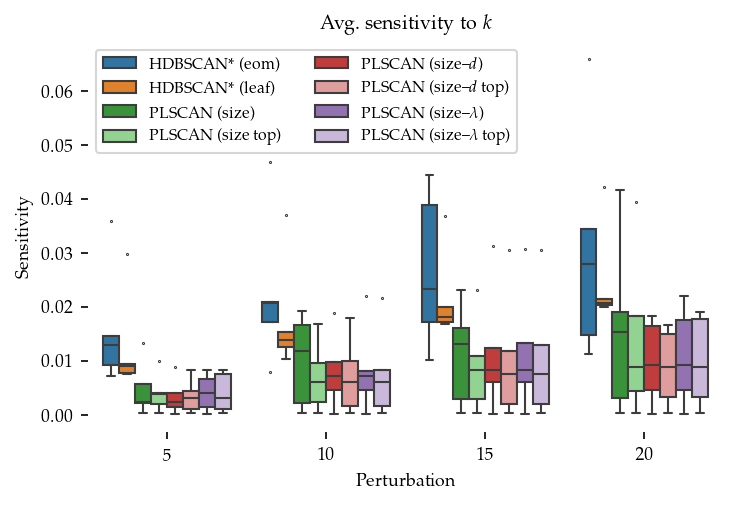

In [40]:
sized_fig(1)

plot_df = df_sens.copy()
plot_df.alg_id = plot_df.alg_id.apply(to_display_name)

alg_order = [0, 1, 3, 2, 5, 4, 7, 6]

ax = sns.boxplot(
    data=plot_df,
    y=plot_df.sensitivity,
    x=pd.Categorical(plot_df.perturbation),
    hue=plot_df.alg_id,
    hue_order=[to_display_name(alg_ids[x]) for x in alg_order],
    palette=[palette[x] for x in alg_order],
    fliersize=0.5,
    linewidth=1,
    legend=True,
)
plt.legend(ncol=2, title="", loc="upper left")
plt.title("Avg.~sensitivity to $k$")
plt.xlabel("Perturbation")
plt.ylabel("Sensitivity")
plt.show()